In [1]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')

In [2]:
from analysis import collection, analysis, plot

from pathlib import Path
import json
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
from sklearn.decomposition import PCA
from analysis import analysis
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection
from matplotlib.colors import to_rgba
from IPython.display import HTML

from matplotlib.gridspec import GridSpec

import matplotlib as mpl
mpl.rcParams.update({'axes.labelsize': 16})

%matplotlib inline

image_path = Path("/Users/spencer/phd/phd/images/basic_results/mean_trajectories")

In [3]:
subjects = analysis.load_subjects()

## number of hits over subjects

In [4]:
hit_fractions = {}
hit_fraction_list = []
for subject in subjects:
    trial_list = []
    for session in subject.tasks["center_hold"].sorted_sessions():
        trial_list.extend(list(session.sorted_trials())) 
    num_trials = len(trial_list)
    hf = (sum([outcome["hits"] for outcome in [session.outcome_counts for session in subject.tasks["center_hold"].sorted_sessions()]]) / num_trials)
    hit_fractions[subject.name] = hf
    hit_fraction_list.append(hf)

In [15]:
sort_idx = np.argsort(hit_fraction_list)
print(sort_idx)
min_subject_idx = sort_idx[0]
median_subject_idx = sort_idx[23]
mean_subject_idx = sort_idx[32]
max_subject_idx = sort_idx[-1]
min_subject = subjects[sort_idx[0]]
median_subject = subjects[sort_idx[23]]
mean_subject = subjects[sort_idx[32]]
max_subject = subjects[sort_idx[-1]]

[19 39 25 45  2 12 23  4  1 10 38 34 14 26  5  9 28 13  7 27 43 44 41 30
 17 20 11 18 36 24  8 32 40 22 42  3 31 15  6 35 37 21  0 33 16 29]


In [6]:
subject_max_lens = []
for subject in subjects:
    max_len = 0
    for session in subject.tasks["center_hold"].sorted_sessions():
        for trial in session.sorted_trials():
            traj = trial.get_trajectory()
            hold_time = trial.hold_time
            if traj.shape[0] > max_len:
                max_len = traj.shape[0]
    subject_max_lens.append(max_len)

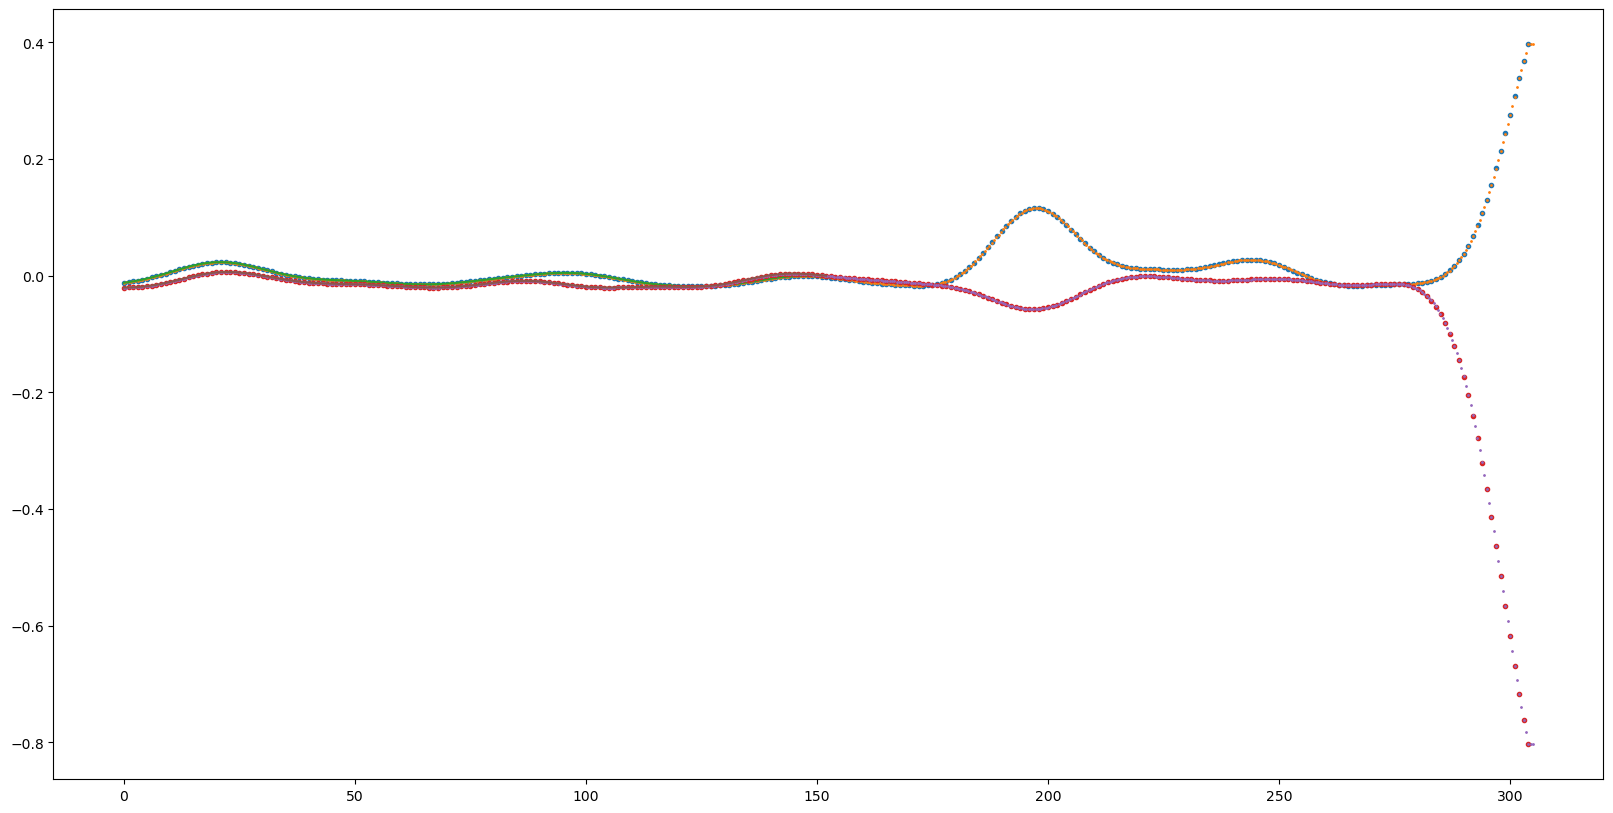

In [7]:
def interp_trajectory(x, traj):
    assert traj.shape[1] == 2
    assert traj.shape[0] > traj.shape[1]
    return np.column_stack([np.interp(x, np.arange(traj.shape[0]),traj[:,0]), np.interp(x, np.arange(traj.shape[0]),traj[:,1])])


x = np.linspace(0,traj.shape[0],traj.shape[0]*2)
interp_traj = interp_trajectory(x,traj)

plt.figure(figsize=(20,10))
plt.plot(traj[:,0],".")
plt.plot(x,interp_traj[:,0],".",markersize=2)
plt.plot(traj[:int(200*hold_time),0])

plt.plot(traj[:,1],".")
plt.plot(x,interp_traj[:,1],".",markersize=2)
plt.plot(traj[:int(200*hold_time),1])

In [8]:
# for trial_idx, trial in enumerate(session.sorted_trials()):
#     print(trial.target_number, trial.recorded_number, trial.number)

In [9]:
def count_nan(data):
    return np.count_nonzero(np.isnan(data))

max_traj_len = 0
for subject in subjects:
    for session in subject.tasks["center_hold"].sorted_sessions():
        for trial in session.sorted_trials():
            hold_steps = int(200*trial.hold_time)
            traj = trial.get_trajectory()[hold_steps:,:]
            if traj.shape[0] > max_len:
                max_len = traj.shape[0]
print("Max trajectory length: " , max_len)

x = np.arange(0,max_len)
# subjects, trials, target, time, channels
interp_traj_stack = np.empty(shape=(len(subjects), 15, 12, max_len, 2))
interp_traj_stack[:] = np.nan
for subject_idx, subject in enumerate(subjects):
    for session_idx, session in enumerate(subject.tasks["center_hold"].sorted_sessions()[:15]):
        for target_idx in range(1,13):
            for trial_idx, trial in enumerate(session.sorted_trials()):
                if trial.outcome == "Hit" and trial.target_number == target_idx:
                    hold_steps = int(200*trial.hold_time)
                    traj = trial.get_trajectory()[hold_steps:,:]
                    if traj.shape[0] < max_len:
                        interp_traj_stack[subject_idx, session_idx, target_idx-1, :, :] = interp_trajectory(x,traj[:,:])
                    else:
                        interp_traj_stack[subject_idx, session_idx, target_idx-1, :, :] = traj[:,:]

print(interp_traj_stack.shape)
print(count_nan(interp_traj_stack))

Max trajectory length:  1589
(46, 15, 12, 1589, 2)
10922786


## hand-picked subjects

In [10]:
best_subjects = [subjects[i] for i in [0, 6, 15, 16, 27, 29, 35, 37, 42]]
very_best_subject_idxs = [0, 6, 29]
very_best_subjects = [subjects[i] for i in very_best_subject_idxs]

## plot mean trajectories

In [12]:
print(interp_traj_stack.shape)
# print(traj_mean.shape)
# print(traj_std.shape)

(46, 15, 12, 1589, 2)


In [13]:
target_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:cyan", "m", "slateblue", "maroon", "teal", "darkslategrey"]

/opt/homebrew/Caskroom/miniconda/base/envs/data_fix/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/dz/870p8tdx43j5527kzthy65zw0000gn/T/ipykernel_23611/2125515959.py:2: RuntimeWarning: Mean of empty slice
  traj_mean = np.nanmean(interp_traj_stack,axis=(1))


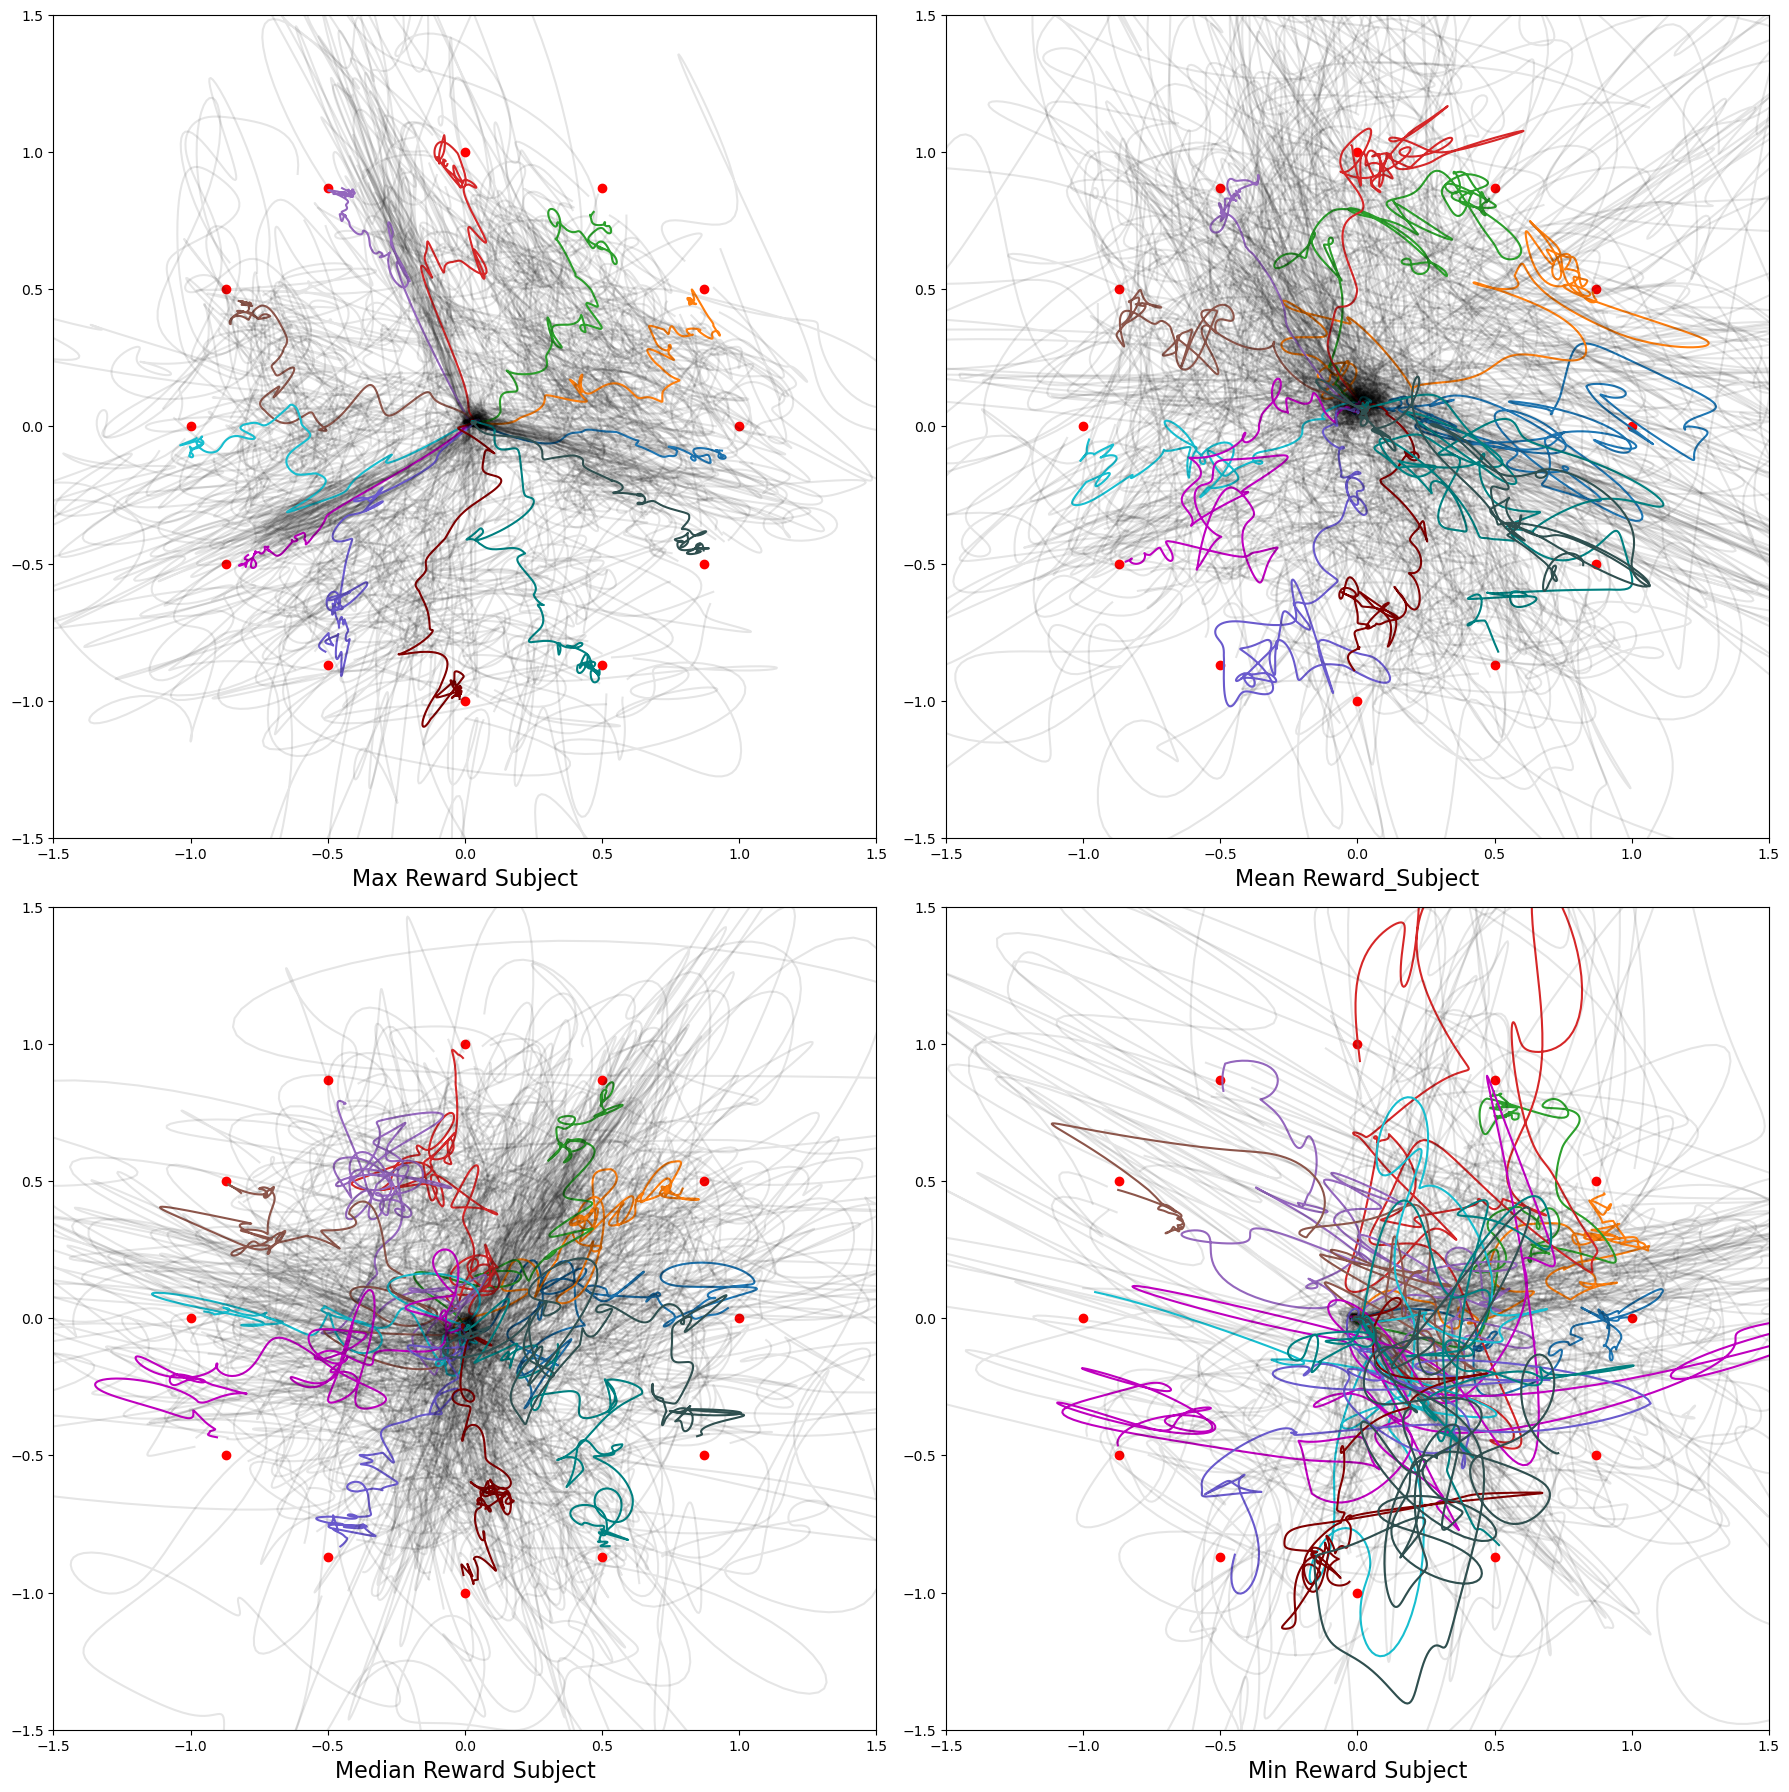

In [17]:
traj_std = np.nanstd(interp_traj_stack,axis=(1))
traj_mean = np.nanmean(interp_traj_stack,axis=(1))
labels = ["Max Reward Subject", "Mean Reward_Subject", "Median Reward Subject", "Min Reward Subject"]

mean_traj_fig, axes = plt.subplots(2,2,figsize=(18,18))
mean_traj_fig.tight_layout()
axes = axes.ravel()
for axi, subject_idx in enumerate([max_subject_idx, mean_subject_idx, median_subject_idx, min_subject_idx]):
    for target_idx in range(12):
        target_vec = collection.compute_target_vec_from_number(target_idx+1)
        axes[axi].plot(target_vec[0],target_vec[1],"ro")
        for i in range(15): 
            try:
                axes[axi].plot(interp_traj_stack[subject_idx,i,target_idx,:,0],interp_traj_stack[subject_idx,i,target_idx,:,1],"k",alpha=0.1)
            except:
                continue
        axes[axi].plot(traj_mean[subject_idx,target_idx,:,0],traj_mean[subject_idx,target_idx,:,1],color=target_colors[target_idx])
    axes[axi].set_xlim([-1.5,1.5])
    axes[axi].set_ylim([-1.5,1.5])
    axes[axi].set_aspect("equal")
    axes[axi].set_xlabel(labels[axi])
mean_traj_fig.tight_layout()

In [18]:
plot.save_figure(mean_traj_fig, "mean_trajectories", image_path)

Figure saved to /Users/spencer/phd/phd/images/basic_results/mean_trajectories/mean_trajectories.pdf
